# MatSci Project 1
### Instron Test Results

I ran instron test on playing cards at three "levels":   
Level 1 - Out of the box  
Level 2 - Science box\* treated, but left to dry at room temperature for a few days  
Level 3 - Straight out of the science box  

\*The science box is a box with a humidifier. Science box treatment involves 30 minute exposure to >95% humidity.

## Calculations

$Stress[MPa] = \frac{load[N]}{(10e6*width[m]*thickness[m])}$  
  
$Strain[m/m] = \frac{dlength[m]}{length[m]}$  
  
$Yield Stress[MPa] = max(Stress[MPa]$)   
$Elongation [\%] = Strain[\%]$ at max Stress  
$Youngs Modulus[MPa] = $slope of stress-strain from extensiometer data  

In [1]:
%matplotlib inline
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from numpy import gradient, argmax, mean, std
import os

level_string = "InstronData/lvl{}.is_tens_RawData"
specimen_string = level_string + "/Specimen_RawData_{}.csv"

In [2]:
class Specimen:
    yield_stress = 0
    yield_strain = 0
    youngs_modulus = 0
        
    def __init__(self, csv_path, hooks_law_bounds):
        # Get data from CSVs
        measurement = read_csv(csv_path, header=0, index_col=0, nrows=2).transpose() # measurements are horizontal => transpose
        data = read_csv(csv_path, header=0, index_col=0, skiprows=4)
        
        # Initial measurements
        self.length = measurement["Length"][0] / 1000.0 # Convert mm to m
        self.width = measurement["Width"][0] / 1000.0
        self.thickness = float(measurement.index[0]) / 1000.0  # First column is the index in a Pandas dataframe
        
        cross_section = self.width * self.thickness # m^2
        
        # Get time series
        self.time = data.index[:] # s
        self.extension = [float(x) / 1000.0 for x in data[1:]["Extension"]] # m, from instron
        self.load = data[1:]["Load"].tolist() # N
        self.displacement = [float(x) / 1000.0 for x in data[1:]["Displacement (Strain 1)"]] # m, from extensiometer
        
        # Calculate secondary time series
        self.stress = [float(x) / (cross_section * 1e6) for x in self.load]
        self.instron_strain = [float(x) / self.length for x in self.extension]
        self.dirty_strain = [float(x) / self.length for x in self.displacement] # Doesn't account for extensiometer removal
        self.extensiometer_strain = self.max_grad_filter(self.dirty_strain)
        
        # Yield point calculation
        self.yield_stress = max(self.stress)
        yield_point_idx = self.stress.index(self.yield_stress)
        self.yield_strain = self.instron_strain[yield_point_idx]
        
        # Young's modulus calculation
        low, high = hooks_law_bounds    # Found by inspection of the graph
        num_samples = 4                 # Sample data to get overall gradient instead of noise
        t_strain = self.extensiometer_strain[low:high] # Get range
        t_stress = self.stress[low:low+len(t_strain)]
        t_strain = t_strain[::len(t_strain) / num_samples] # Sample
        t_stress = t_stress[::len(t_stress) / num_samples]
        self.youngs_modulus = mean(gradient(t_stress, t_strain))
        
        
    def plot_stress_strain(self, source, label):
        if source.lower() == "instron":
            strain = self.instron_strain
        elif source.lower() == "extensiometer":
            strain = self.extensiometer_strain
        else:
            print("Unkown strain source")
            return None
        
        plt.plot(strain, self.stress, label="#{}".format(label))
        
    
    def max_grad_filter(self, array):
        grad = abs(gradient(array))
        stop_index = argmax(grad)
        return array[:stop_index]

        
class Level:      
    def __init__(self, level_names, hooks_law_bounds=(90, 160)):
        # Type checks (aka slowing your code down)
        if type(level_names) == int:
            level_names = str(level_names)

        if type(level_names) == str:
            level_names = [level_names]

        self.level_name = level_names[0]
        
        # Make list of specimen
        self.specimen_list = []
        for level_name in level_names:
            num_specimen = len(os.listdir(level_string.format(level_name)))
            for specimen in range(1, num_specimen + 1):
                self.specimen_list.append(Specimen(specimen_string.format(level_name, specimen), hooks_law_bounds))
                
        # Make aggregate calculations
        self.youngs_modulus, self.youngs_modulus_std, self.youngs_modulus_err = self.aggregate("youngs_modulus")
        self.yield_stress, self.yield_stress_std, self.yield_stress_err = self.aggregate("yield_stress")
        self.yield_strain, self.yield_strain_std, self.yield_strain_err = self.aggregate("yield_strain")

        
        
    def aggregate(self, value):
        value_list = [getattr(spec, value) for spec in self.specimen_list]
        average = mean(value_list)
        deviation = std(value_list)
        error = deviation / average
        return (average, deviation, error)
                
    def __len__(self):
        return len(self.specimen_list)
    
    
    def __delitem__(self, idx):
        del self.specimen_list[idx]
        
        
    def __getitem__(self, idx):
        return self.specimen_list[idx]
    
    
    def plot(self, source="instron"):
        plt.figure()
        spec_num = 1

        for specimen in self.specimen_list:
            specimen.plot_stress_strain(source, spec_num)

            spec_num += 1

        plt.legend(loc=9, bbox_to_anchor=(1.2, 0.95))
        plt.xlabel("Strain (mm/mm)")
        plt.ylabel("Stress (MPa)")
        plt.title("Level {}".format(self.level_name))
        plt.show()

In [3]:
# Get level data
level1 = Level(["1", "1_1"])
level2 = Level(["2", "2_2"])
level3 = Level(3)

print("""Just to check:
level1 has {} specimens
level2 has {} specimens
level3 has {} specimens
""".format(len(level1), len(level2), len(level3)))

Just to check:
level1 has 11 specimens
level2 has 11 specimens
level3 has 10 specimens



## First look at our data

Note: Around 23 mm/mm, we get a spike corresponding to the removal of the extensiometer.

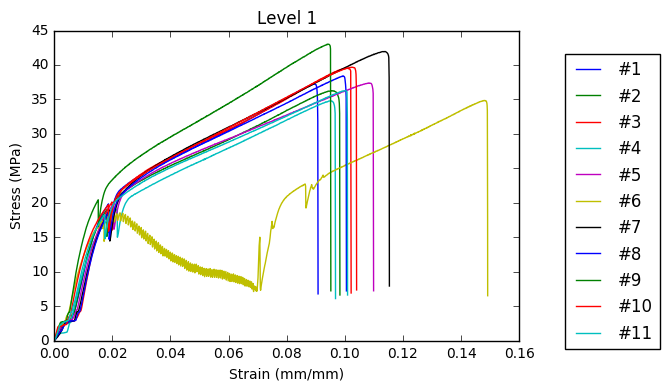

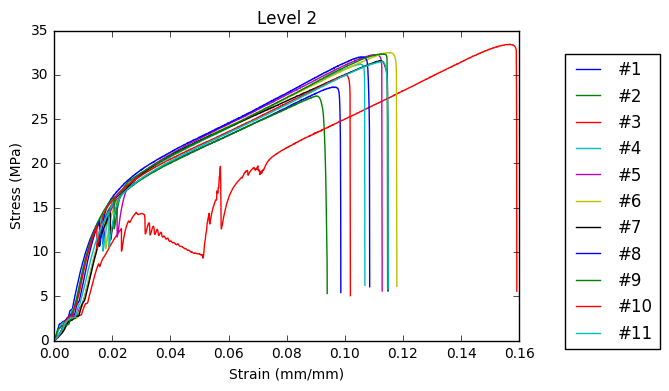

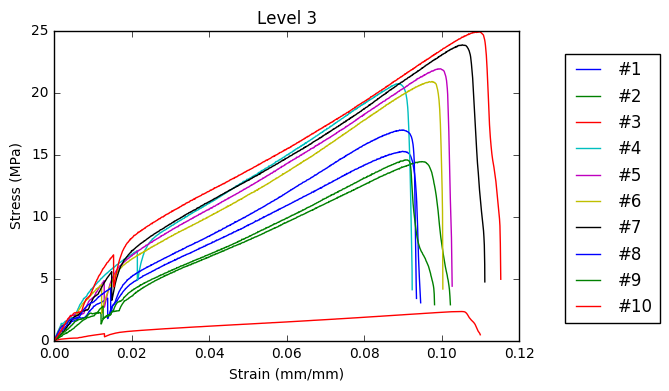

In [4]:
level1.plot()
level2.plot()
level3.plot()

It's clear from these plots data is garbage for level 1, specimen 6 and level 2, specimen 3. So we'll go ahead and drop those.

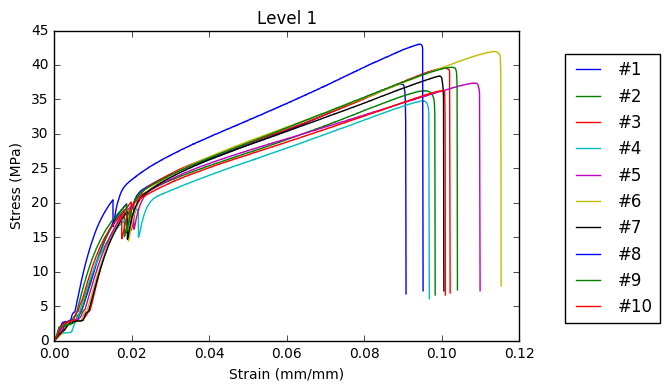

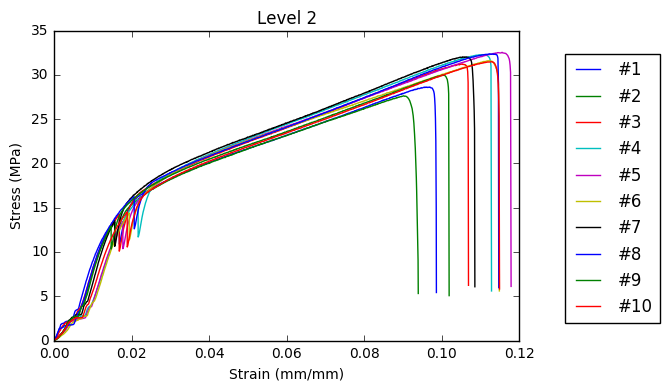

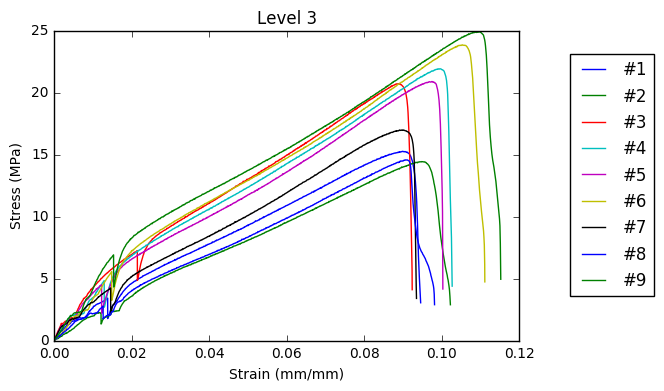

In [5]:
del level1[5]
del level2[2]
del level3[2]

level1.plot()
level2.plot()
level3.plot()

## Young's Modulus 
To find the young's modulus, I found the area of interest by inspection. Level 3 looks bad because the data is a lot more shaky, but it should be fine.

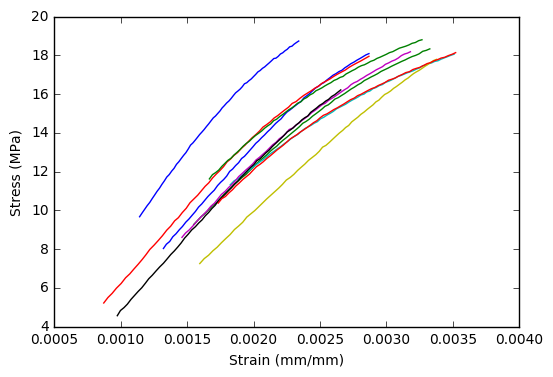

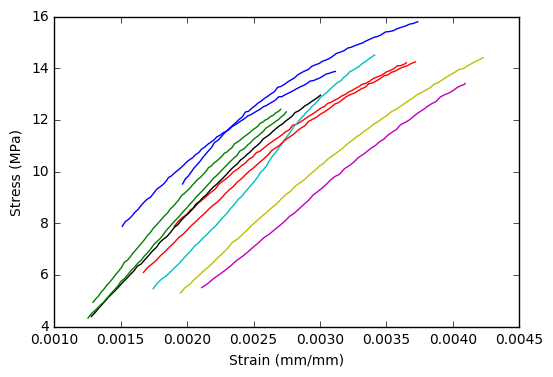

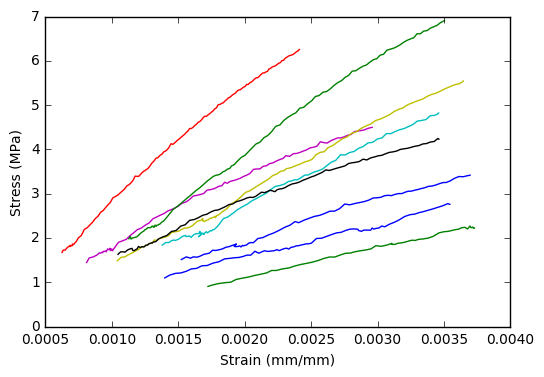

In [6]:
def plot_extensiometer_slope(level, bounds=(90, 160)):
    low, high = bounds
    plt.figure()
    n = 1
    for spec in level:
        strain = spec.extensiometer_strain[low:high]
        stress = spec.stress[low:low+len(strain)]
        plt.plot(strain, stress, label=str(n))
        n+=1    
    
    plt.xlabel("Strain (mm/mm)")
    plt.ylabel("Stress (MPa)")

plot_extensiometer_slope(level1)
plot_extensiometer_slope(level2)
plot_extensiometer_slope(level3, (40, 180))

## Results
##### CES values:  
  
Young's Modulus: 2-4 GPa  
Yield Strength: 15-34 MPa  
Elongation: 0.38-1.7 %  

##### Experimental values:

In [7]:
def print_value(level, value, error, unit):
    print("{}: {:.2e} {} +- {:.2f}%".format(level, value, unit, error))

print("Young's Modulus")
print_value("level 1", level1.youngs_modulus, level1.youngs_modulus_err * 100, "MPa")
print_value("level 2", level2.youngs_modulus, level2.youngs_modulus_err * 100, "MPa")
print_value("level 3", level3.youngs_modulus, level3.youngs_modulus_err * 100, "MPa")


print
print("Yield Strength")
print_value("level 1", level1.yield_stress, level1.yield_stress_err * 100, "MPa")
print_value("level 2", level2.yield_stress, level2.yield_stress_err * 100, "MPa")
print_value("level 3", level3.yield_stress, level3.yield_stress_err * 100, "MPa")

print
print("Elongation")
print_value("level 1", level1.yield_strain, level1.yield_strain_err * 100, "%")
print_value("level 2", level2.yield_strain, level2.yield_strain_err * 100, "%")
print_value("level 3", level3.yield_strain, level3.yield_strain_err * 100, "%")


Young's Modulus
level 1: 1.27e+03 MPa +- 34.01%
level 2: 8.36e+02 MPa +- 20.42%
level 3: 1.48e+02 MPa +- 81.29%

Yield Strength
level 1: 3.81e+01 MPa +- 6.76%
level 2: 3.12e+01 MPa +- 5.41%
level 3: 1.76e+01 MPa +- 35.49%

Elongation
level 1: 1.04e-01 % +- 14.57%
level 2: 1.11e-01 % +- 14.82%
level 3: 9.71e-02 % +- 7.29%
